In [4]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import os
import random
from glob import glob
import nibabel as nib 
from tqdm import tqdm
from PIL import Image
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from base_dataset import BaseDataset
from image_folder import make_dataset

In [19]:
class UnalignedDataset(Dataset):
    """
    Dataset class for mulitpath kernel conversion. Loads in nine kernels and returns the corresponding images.
    """

    def __init__(self):
        """Initialize this dataset class.

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """

        #When training for four domains, use this code from lines 33-51
        self.dir_A = os.path.join("/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/train_slices/inspiratory_BONE")  
        self.dir_B = os.path.join("/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/train_slices/expiratory_STANDARD") 
        print(self.dir_A)
        print(self.dir_B)
        self.A_paths = sorted(make_dataset(self.dir_A, float("inf")))   
        self.B_paths = sorted(make_dataset(self.dir_B, float("inf")))    
        self.A_size = len(self.A_paths)  # get the size of dataset A
        self.B_size = len(self.B_paths)  # get the size of dataset B
        # input_nc = self.opt.input_nc    
        # output_nc = self.opt.output_nc    

        #Robust way of doing clipping 
        self.normalizer = interp1d([-1024,3072], [-1,1])

    def __getitem__(self, index):
        """Return a data point and its metadata information.

        Parameters:
            index (int)      -- a random integer for data indexing

        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor)       -- an image in the input domain
            B (tensor)       -- its corresponding image in the target domain
            A_paths (str)    -- image paths
            B_paths (str)    -- image paths
        """
        # Get the dataitems for 4 domains
        A_path = self.A_paths[index % self.A_size]  # make sure index is within then range
        index_B = random.randint(0, self.B_size - 1)
        B_path = self.B_paths[index_B]
        
        A = self.normalize(A_path)
        B = self.normalize(B_path)
    
        #Return a tuple of the kernel data instead of an indivodual kernel. (Needs to be implemented)
        return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path} 

    def __len__(self):
        """Return the total number of images in the dataset.

        As we have different datasets with potentially different number of images,
        we take a maximum of all the datasets.
        """
        return max(self.A_size, self.B_size)
        # return max(self.subset_A, self.subset_B, self.subset_C, self.subset_D)


    def normalize(self, input_slice_path):
        """Normalize input slice and return as a tensor ranging from [-1,1]"""
        nift_clip = np.clip(nib.load(input_slice_path).get_fdata()[:,:,0], -1024, 3072)
        cropped_image = self.random_crop(image = nift_clip, crop_size=(128,128)) # Apply a random crop to get a patch of size 128 x 128
        norm = self.normalizer(cropped_image)
        tensor = torch.from_numpy(norm)
        torch_tensor = tensor.unsqueeze(0).float()
        return torch_tensor


    def random_crop(self, image, crop_size = (128,128)):
        """
        Random crop to get a patch of size 128 x 128
        """
        h, w = image.shape
        y = np.random.randint(0, h - crop_size[0])
        x = np.random.randint(0, w - crop_size[1])
        return image[y:y + crop_size[0], x:x + crop_size[1]]

/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/train_slices/inspiratory_BONE
/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/train_slices/expiratory_STANDARD


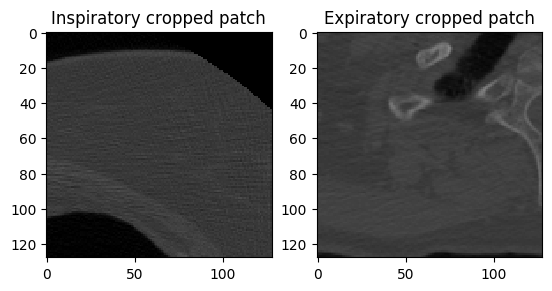

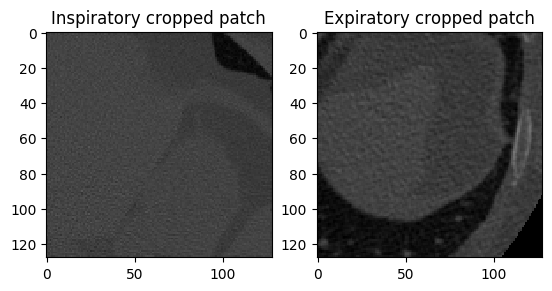

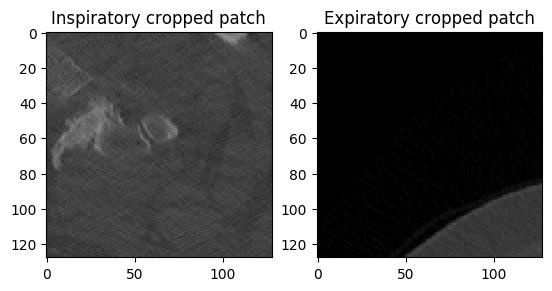

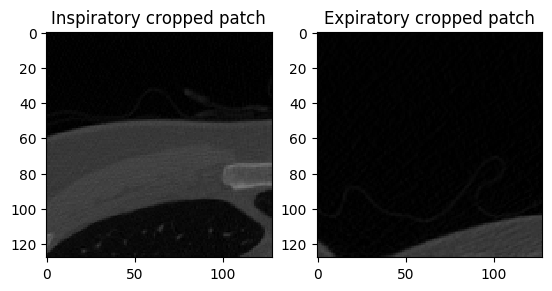

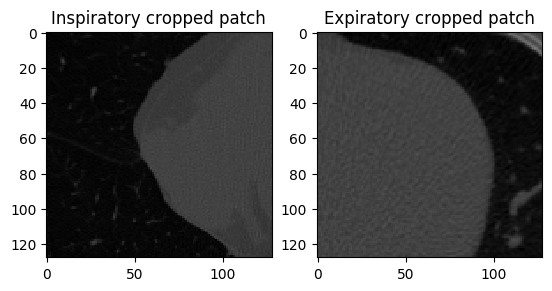

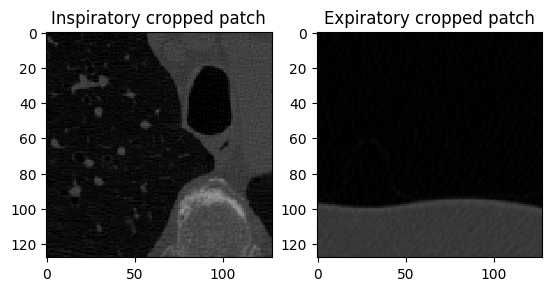

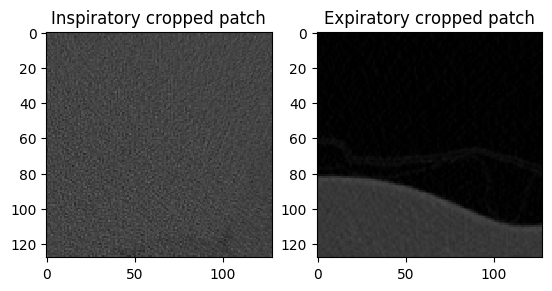

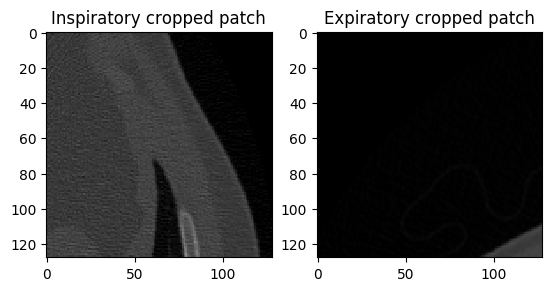

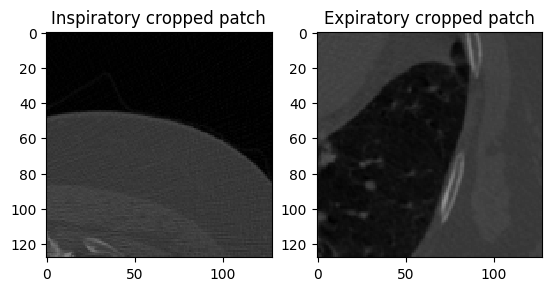

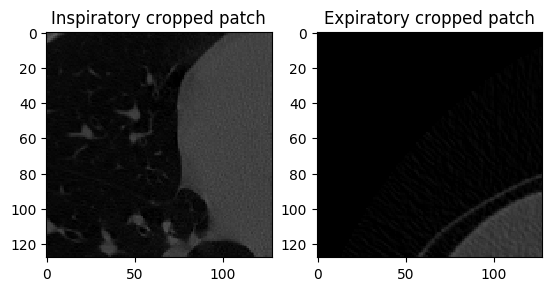

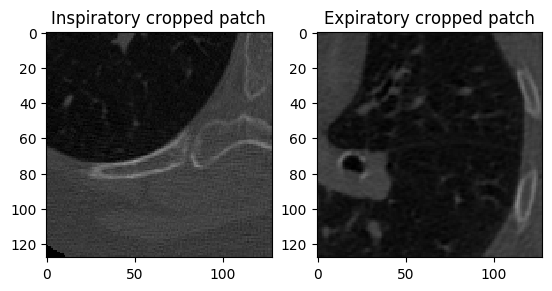

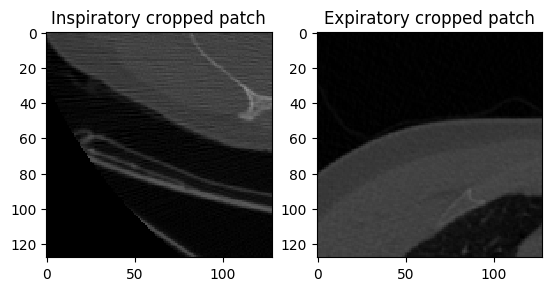

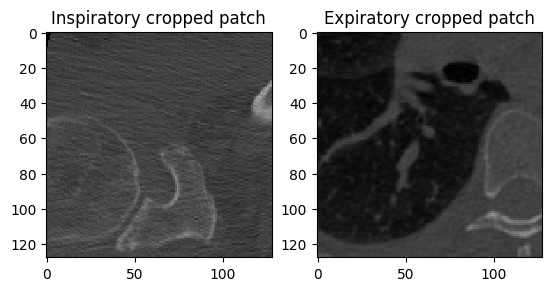

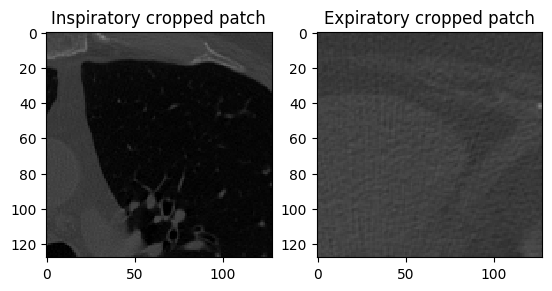

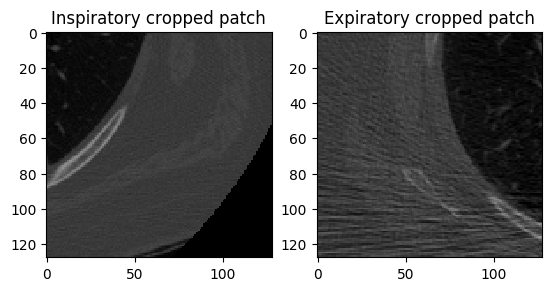

In [23]:
dataload = DataLoader(UnalignedDataset(), batch_size = 15, shuffle = True)
#Plot the first batch of images
for i, data in enumerate(dataload):
    if i == 0:
        A = data['A']
        B = data['B']
        for j in range(A.size(0)):
            plt.subplot(1, 2, 1)
            plt.imshow(np.rot90(A[j].squeeze(0)), cmap = 'gray', vmin=-1, vmax=1)
            plt.title('Inspiratory cropped patch')
            plt.subplot(1, 2, 2)
            plt.imshow(np.rot90(B[j].squeeze(0)), cmap = 'gray', vmin=-1, vmax=1)
            plt.title("Expiratory cropped patch")
            plt.show()
    break